In [2]:
import muon as mu
import scanpy as sc

import atac2space as a2s

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = '/vol/storage/data/Russell/Russell_melanoma.h5mu'

In [4]:
mdata = mu.read(data_path)

In [5]:
adata = mdata['atac']

In [6]:
adata

AnnData object with n_obs × n_vars = 2535 × 53451
    obs: 'barcodes', 'NAME_x', 'X', 'Y', 'cell_type', 'NAME_y', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster'
    var: 'features'
    uns: 'cell_type_colors'
    obsm: 'X_umap', 'spatial'

In [7]:
# reads to fragments
a2s.pp.reads_to_fragments(adata)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


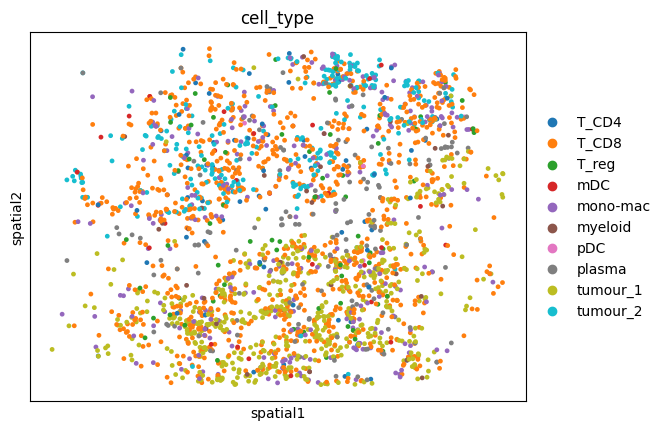

In [8]:
sc.pl.embedding(adata, basis='spatial', color='cell_type')

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vo

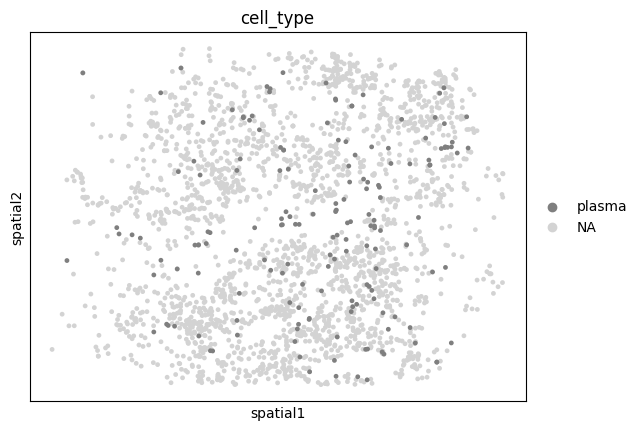

In [10]:
sc.pl.embedding(adata, basis='spatial', color='cell_type', groups='plasma')

## Simulate Visium data

In [19]:
# from https://github.com/QuKunLab/SpatialBenchmarking/blob/main/SimulatedData.ipynb
import numpy as np
import pandas as pd
import os
import scipy

def Simulated(adata, window, layer=None):
    combined_spot = []
    combined_spot_loc = []

    spatial_loc = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])
    for x in np.arange((spatial_loc['x'].min()//window),spatial_loc['x'].max()//window+1):
        for y in np.arange((spatial_loc['y'].min()//window),spatial_loc['y'].max()//window+1):
            tmp_loc = spatial_loc[(x*window < spatial_loc['x']) & (spatial_loc['x'] < (x+1)*window) &\
                                   (y*window < spatial_loc['y']) & (spatial_loc['y'] < (y+1)*window)]
            if len(tmp_loc) > 0:
                combined_spot_loc.append([x,y])
                combined_spot.append(tmp_loc.index.to_list())
            
    combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot],columns=['cell_count'])
    combined_spot_loc = pd.DataFrame(combined_spot_loc, columns=['x','y'])

    combined_spot_exp = []
    for s in combined_spot:
        if layer is None:
            combined_spot_exp.append(adata[s,:].X.sum(axis=0))
        else:
            combined_spot_exp.append(adata[s,:].layers[layer].sum(axis=0))
    
    combined_spot_exp = np.concatenate(combined_spot_exp, axis=0).reshape(len(combined_spot),-1)

    combined_spot_clusters = pd.DataFrame(np.zeros((len(combined_spot_loc.index),len(np.unique(adata.obs['cell_type'])))), columns=np.unique(adata.obs['cell_type']))
    for i,c in enumerate(combined_spot):
        for clt in adata[c, :].obs['cell_type']:
            combined_spot_clusters.loc[i,clt] += 1


    adata_st = sc.AnnData(
        scipy.sparse.csr_matrix(combined_spot_exp), 
        obs=combined_cell_counts, 
        var=adata.var, 
        obsm={'proportions': (combined_spot_clusters/combined_cell_counts.values).values, 'spatial': combined_spot_loc.values}, 
        uns={'proportion_names': combined_spot_clusters.columns.to_list()}
        )
    return adata_st

### ATAC

In [20]:
adata_st = Simulated(adata, 100, layer='fragments')

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and 

In [21]:
adata_st_150 = Simulated(adata, 150, layer='fragments')

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and 

### RNA

In [24]:
mdata['rna'].X.max()

4627.0

In [25]:
adata_st_rna_150 = Simulated(mdata['rna'], 150, layer=None)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and 

In [26]:
adata_st_rna_100 = Simulated(mdata['rna'], 100, layer=None)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and 

### Visualize the simulated data

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


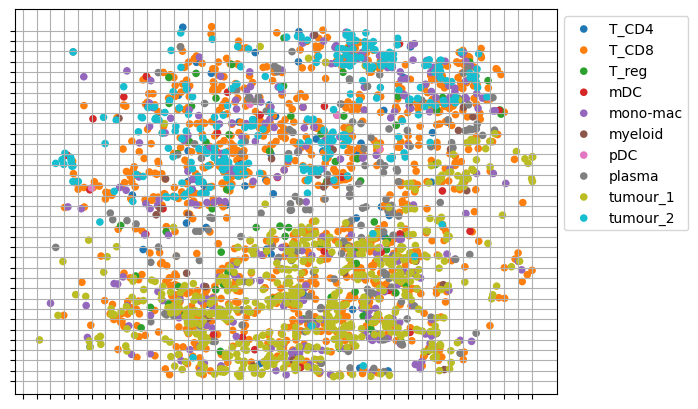

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
fig,ax = plt.subplots(figsize=(7,5))
cmap = adata.uns['cell_type_colors']
for i,c in enumerate(np.unique(adata.obs.cell_type)):
    ax.scatter(
        x=adata[adata.obs.cell_type == c, :].obsm['spatial'][:, 0],
        y=adata[adata.obs.cell_type == c, :].obsm['spatial'][:, 1],
        c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-6000,-400,150))
plt.yticks(np.arange(-5700,-500,150))

plt.grid()
# remove xticks
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


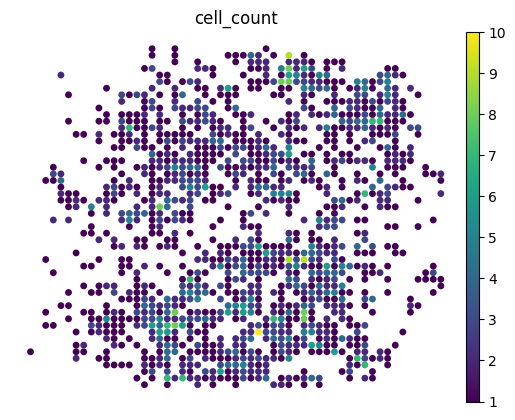

In [30]:
sc.pl.embedding(adata_st, basis='spatial', color='cell_count', frameon=False)

### Save simulated data

In [27]:
adata_st.write('/vol/storage/data/simulations/atac_russell_100.h5ad')

In [28]:
adata_st_150.write('/vol/storage/data/simulations/atac_russell_150.h5ad')

In [29]:
adata_st_rna_150.write('/vol/storage/data/simulations/rna_russell_150.h5ad')
adata_st_rna_100.write('/vol/storage/data/simulations/rna_russell_100.h5ad')

## Save reference

In [36]:
#clean up
adata = sc.AnnData(X=scipy.sparse.csr_matrix(adata.layers['fragments']), obs=adata.obs, var=adata.var, obsm=adata.obsm, uns=adata.uns)

In [37]:
mu.atac.pp.tfidf(adata, to_layer = "tfidf_normalized")

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


In [39]:
a2s.pp.highly_variable_peaks(adata, cluster_key='cell_type')

In [40]:
adata.write('/vol/storage/data/simulations/atac_ref.h5ad')

In [41]:
adata_rna = mdata['rna'].copy()

In [42]:
adata_rna.layers['counts'] = adata_rna.X.copy()

In [43]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)

sc.pp.highly_variable_genes(adata_rna, n_top_genes=4000)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [44]:
adata_rna

AnnData object with n_obs × n_vars = 2535 × 36601
    obs: 'barcodes', 'NAME_x', 'X', 'Y', 'cell_type', 'NAME_y', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster'
    var: 'ens', 'gene', 'type', 'chromosome', 'start', 'end', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_umap', 'spatial'
    layers: 'counts'

In [45]:
adata_rna.write('/vol/storage/data/simulations/rna_ref.h5ad')